In [2]:
from IPython.display import Audio
import librosa
import numpy as np
from torch.utils.data import DataLoader
from datasets import load_dataset, concatenate_datasets
import matplotlib.pyplot as plt
from flower_kws.audio import (get_apply_transforms_fn, balance_dataset,
                              flatten_all_segments, segment_silences)

The purpose of this notebook is to introduce the [`Google Speech Commands dataset`](https://arxiv.org/abs/1804.03209). It's the dataset used by the Flower App in this repository too. This dataset will be used to train a keyword spotting (KWS) model in a federated way. There will be ~100 clients, each containing audio clips from about 20 unique speakers.

The Speech Commands datasets is comprised of 105,829, 16KHz 1-second long audio clips of a spoken word (e.g. "yes", "up", "stop") and the task is to classify these in a 12 or 35 classes setting. The datasets comes pre-partitioned into 35 classes and in order to obtain the 12-classes version, the standard approach is to keep 10 classes of interest (i.e. "yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"), place the remaining 25 under the "unknown" class and, introduce a new class "silence" where no spoken word appear is the audio clip. Here we use SpeechCommandsV2, the most recent version of this dataset. The dataset spans three disjoint set of speakers: 2112 form the training set, 256 for validation and, 250 for testing.

In [3]:
# Load train split (it will download it if not found)
sc_train = load_dataset("speech_commands", "v0.02", split="train", token=False)

### Getting to know the dataset

In [4]:
sc_train

Dataset({
    features: ['file', 'audio', 'label', 'is_unknown', 'speaker_id', 'utterance_id'],
    num_rows: 84848
})

We can compute the histogram of the dataset too. Note how some classes have about double the training examples than others. This isn't ideal for training. We'll handle it later because first we want to transform this 12-classes dataset into a 12-classes one: 10 known words + 'unknown' + 'silence'.

But first, let's see how the 35-classes distribution looks like

Text(0.5, 1.0, 'Number of audio clips for each class in SpeechCommands (35 cls)')

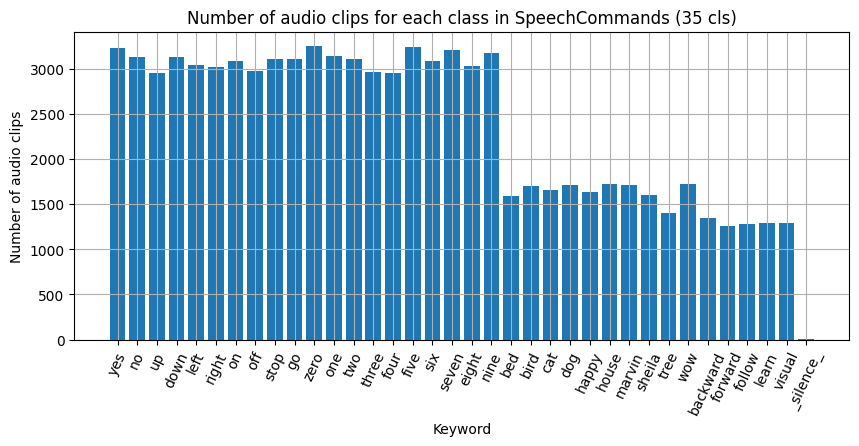

In [5]:
_, ax = plt.subplots(figsize = (10,4))
cls_35 = list(sc_train.features['label'].names)
count = np.histogram(sc_train["label"], bins=36)[0]
xticks = range(len(cls_35))
ax.bar(xticks, count)
ax.set_xticks(xticks)
ax.set_xticklabels(cls_35, rotation=65)
ax.grid()
ax.set_xlabel('Keyword')
ax.set_ylabel('Number of audio clips')
ax.set_title('Number of audio clips for each class in SpeechCommands (35 cls)')

In [6]:
# Apply processing ('mfcc' and 'target' columns will appear)
train_set = sc_train.map(get_apply_transforms_fn(), batch_size=1024)
train_set.set_format(type="torch", columns=["mfcc", "target"])
train_set

Dataset({
    features: ['file', 'audio', 'label', 'is_unknown', 'speaker_id', 'utterance_id', 'mfcc', 'target'],
    num_rows: 84848
})

Let's inspect one of the audio clips

In [7]:
i = 11111
# Let's use the i-th sample
sample = train_set['audio'][i]
waveform, sr = sample['array'], sample['sampling_rate']
print(f"{waveform.shape = }")
print(f"{sr = }")

# Now let's get the label
label_idx = train_set['label'][i]
label_str = train_set.features['label'].names[label_idx]
print(f"label = '{label_str}'")

# Let's listen to it
Audio(waveform, rate=sr, autoplay=True)


waveform.shape = (16000,)
sr = 16000
label = 'down'


Let's use `librosa` to visualize the waveform as well as the spectogram of that 1 second audio clip

spectogram.shape = (1025, 32)


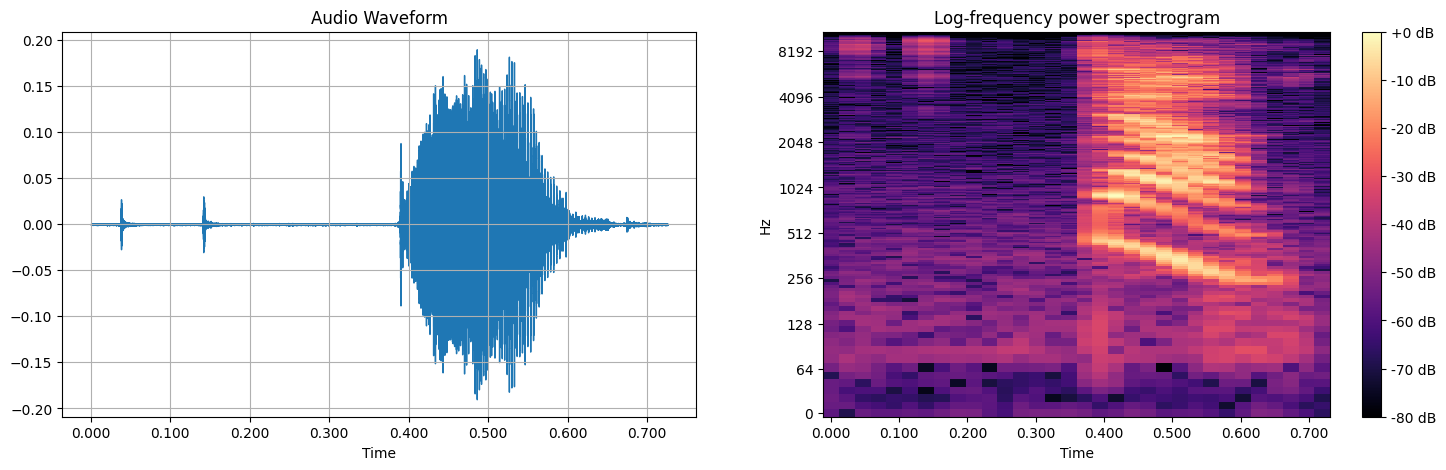

In [8]:
plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
librosa.display.waveshow(waveform) # plot waveform
plt.title('Audio Waveform')
plt.grid()

plt.subplot(1, 2, 2)
spectogram = librosa.amplitude_to_db(np.abs(librosa.stft(waveform)), ref=np.max)
print(f"{spectogram.shape = }")
librosa.display.specshow(spectogram, x_axis='time', y_axis='log') # plot spectrogram in log scale
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')
plt.xlabel('Time')
plt.show()

We could use the spectogram as 2d features to train our KWS model. Howerver, we'll be using the more compact Mel-Frequency Cepstral Coefficients (MFCC) features instead. Let's take a look at how they compare.

mfccs.shape = (40, 32)


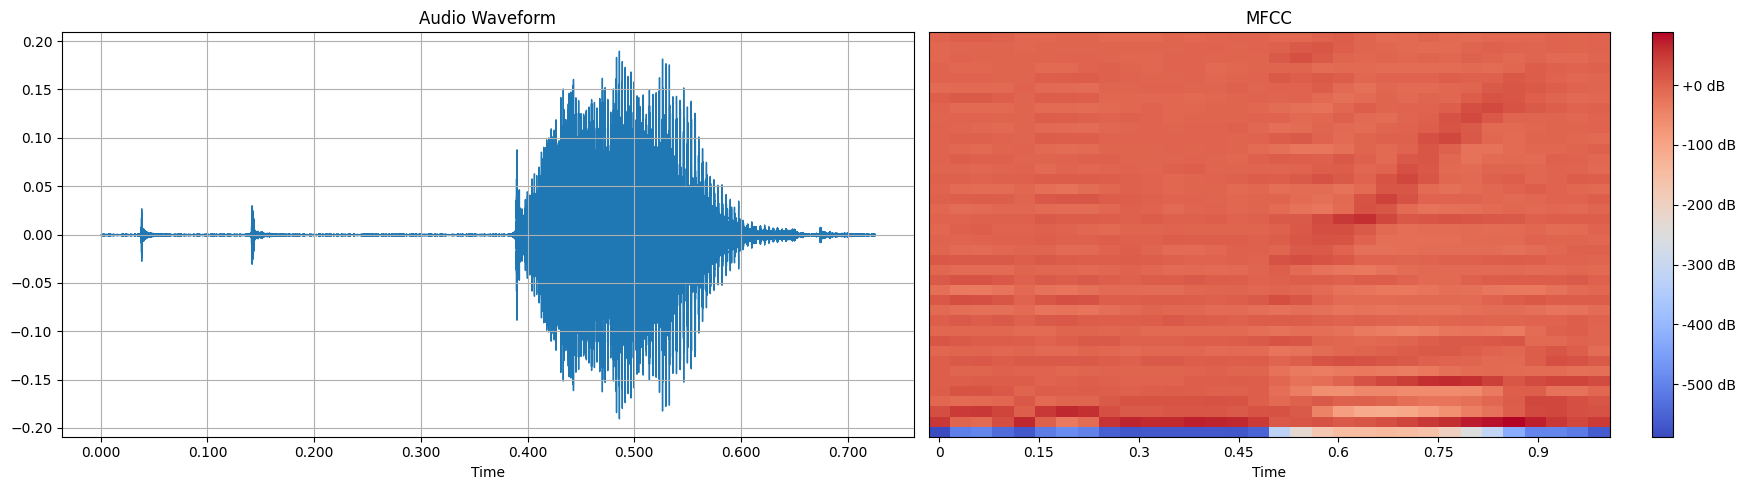

In [9]:
plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
librosa.display.waveshow(waveform) # plot waveform
plt.title('Audio Waveform')
plt.grid()

plt.subplot(1, 2, 2)
# Extract MFCCs
mfccs = librosa.feature.mfcc(y=waveform, sr=sr, n_mfcc=40)
print(f"{mfccs.shape = }")
librosa.display.specshow(mfccs, x_axis='time', sr=sr)
plt.colorbar(format="%+2.0f dB")
plt.title("MFCC")
plt.xlabel('Time')
plt.tight_layout()
plt.show()

We can adjust the settings of our MFCC compuatation:

mfccs.shape = (40, 51)


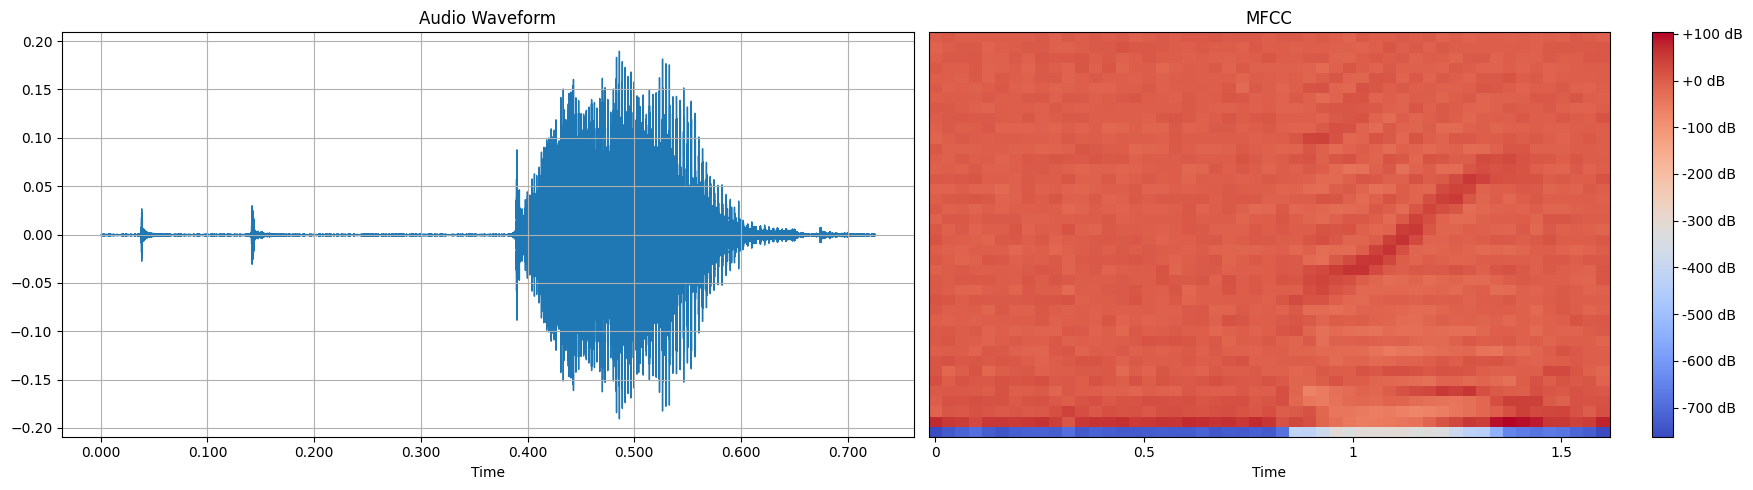

In [10]:
plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
librosa.display.waveshow(waveform) # plot waveform
plt.title('Audio Waveform')
plt.grid()
plt.subplot(1, 2, 2)
# Extract MFCCs
ss = 8000
n_mfcc = 40
window_width = 0.040  # 40 ms
stride = 0.020        # 20 ms
n_fft = 400
y_resampled = librosa.resample(waveform, orig_sr=sr, target_sr=ss)
mfccs = librosa.feature.mfcc(
    y=y_resampled,
    sr=ss,
    n_mfcc=n_mfcc,
    n_fft=n_fft,
    win_length=int(ss * window_width),
    hop_length=int(ss * stride),
    window="hann"  # default, matches PyTorch behavior
)
print(f"{mfccs.shape = }")
librosa.display.specshow(mfccs, x_axis='time', sr=sr)
plt.colorbar(format="%+2.0f dB")
plt.title("MFCC")
plt.xlabel('Time')
plt.tight_layout()
plt.show()

Actually the above parameterization of how MFCCs are extracted is exactly what was done earlier when transforming the training set (via `.map()` at the top of this notebook). Let's verify this is the case by checking the shape of the MFCC features (it should be `[40x51]`). Let's visualize them too

train_set[i]["mfcc"].shape = torch.Size([1, 40, 51])


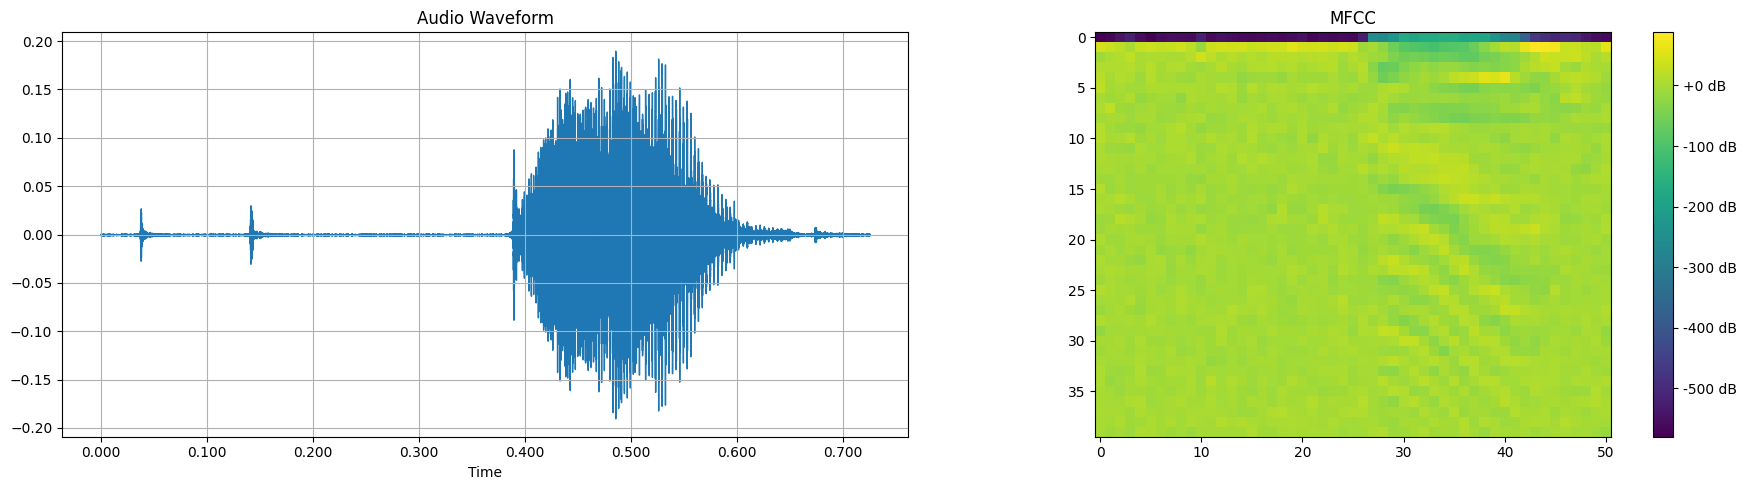

In [11]:
print(f'{train_set[i]["mfcc"].shape = }')
# They would look flipped compared to what librosa displayed. This is fine.

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
librosa.display.waveshow(waveform) # plot waveform
plt.title('Audio Waveform')
plt.grid()

plt.subplot(1, 2, 2)
plt.imshow(train_set[i]["mfcc"][0])
plt.colorbar(format="%+2.0f dB")
plt.title("MFCC")
plt.tight_layout()
plt.show()


### Dataset is imbalanced

Let's compute the histogram of the whole training set. As you can see, our processing of the dataset has a big problem: since we reduced the number of classes from 35 to 12, all the training examples labelled as _unknown_ fall into the same category.

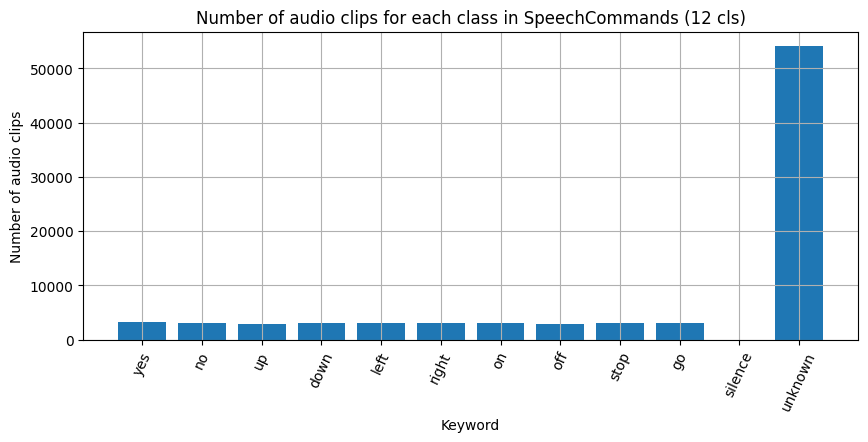

In [12]:
def viz_histogram(dataset_row):
    _, ax = plt.subplots(figsize = (10,4))
    cls_12 = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence', 'unknown']
    count = np.histogram(dataset_row, bins=12)[0]
    xticks = range(len(cls_12))
    ax.bar(xticks, count)
    ax.set_xticks(xticks)
    ax.set_xticklabels(cls_12, rotation=65)
    ax.grid()
    ax.set_xlabel('Keyword')
    ax.set_ylabel('Number of audio clips')
    ax.set_title('Number of audio clips for each class in SpeechCommands (12 cls)')

viz_histogram(train_set["target"])


Before handling this, let's add some _silence_ examples to our dataset. We do this by extracting a few 1-second segments from the different background sound clips provided in the dataset.

In [ ]:
silences = sc_train.filter(lambda x: x["label"] == 35)
print(silences)
# Let's generate ~10% of silence clips (2.0% for each of the 5 background sounds)
num_silences = int(len(sc_train) * 0.02)
print(f"{num_silences = }")
silence_segments = silences.map(segment_silences(num_silences))
flattened_silences_dataset = silence_segments.map(
    flatten_all_segments, batched=True
)

# You should see ~8.5K rows
print(flattened_silences_dataset)

Dataset({
    features: ['file', 'audio', 'label', 'is_unknown', 'speaker_id', 'utterance_id'],
    num_rows: 5
})
num_silences = 1696


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Dataset({
    features: ['file', 'audio', 'label', 'is_unknown', 'speaker_id', 'utterance_id'],
    num_rows: 8480
})


Let's inspect one of the audio clips

In [26]:
i = 2048
# Let's use the i-th sample
sample = flattened_silences_dataset['audio'][i]
waveform, sr = sample['array'], sample['sampling_rate']
Audio(waveform, rate=sr, autoplay=True)

Let's add the generated background segments to the datasets we had before. But first! Let's stract the MFCC features for all segments

In [27]:
# Transform silence dataset
silence_enc = flattened_silences_dataset.map(
    get_apply_transforms_fn(), batch_size=32)

# Let's remove columns we no longer need
REMOVE_COLS = ["file", "audio", "label", "is_unknown", "speaker_id", "utterance_id"]
train_set = train_set.remove_columns([c for c in train_set.column_names if c in REMOVE_COLS])
silence_enc = silence_enc.remove_columns([c for c in silence_enc.column_names if c in REMOVE_COLS])

# Finally, concatenate
full_train_set = concatenate_datasets([train_set, silence_enc])
# full_train_set = full_train_set.shuffle()

Map:   0%|          | 0/8480 [00:00<?, ? examples/s]

Let's generate again the histogram. Now we should clearly see the `silence` entries

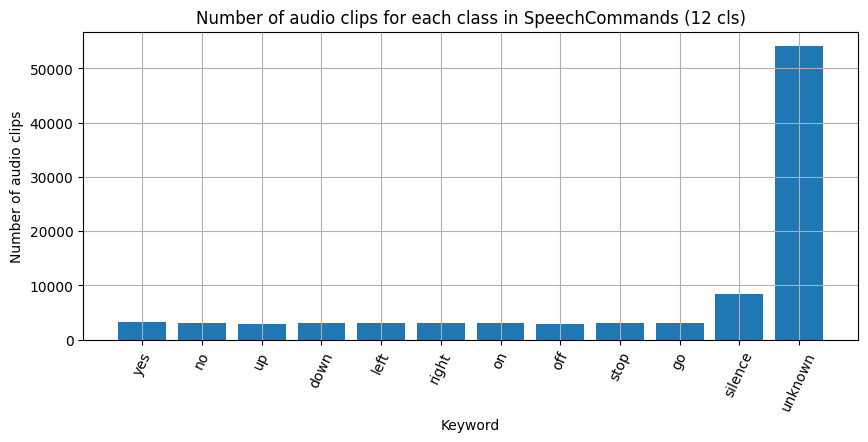

In [28]:
viz_histogram(full_train_set["target"])

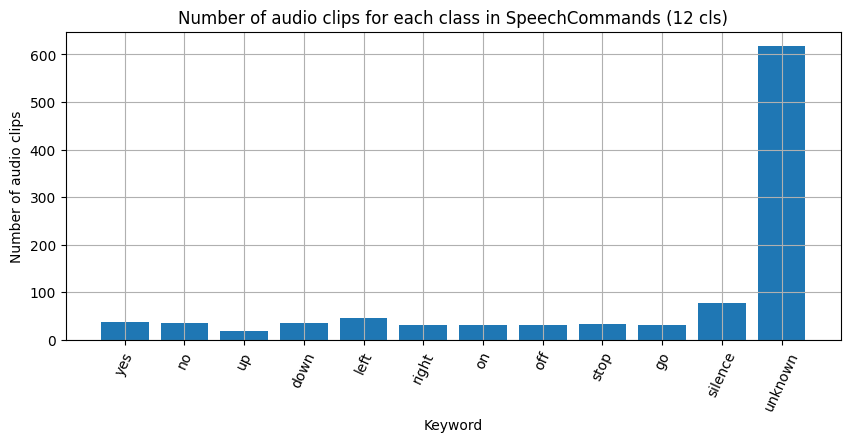

In [29]:
# Let's verify this remains an issues when extracting a batch from the dataset
train_loader = DataLoader(full_train_set, batch_size=1024, shuffle=True)

# Let's extract the first batch
batch = next(iter(train_loader))

# Indeed you'll see the same distribution
viz_histogram(batch["target"])

We can _balance_ the dataset by oversampling those clips that appear less frequently

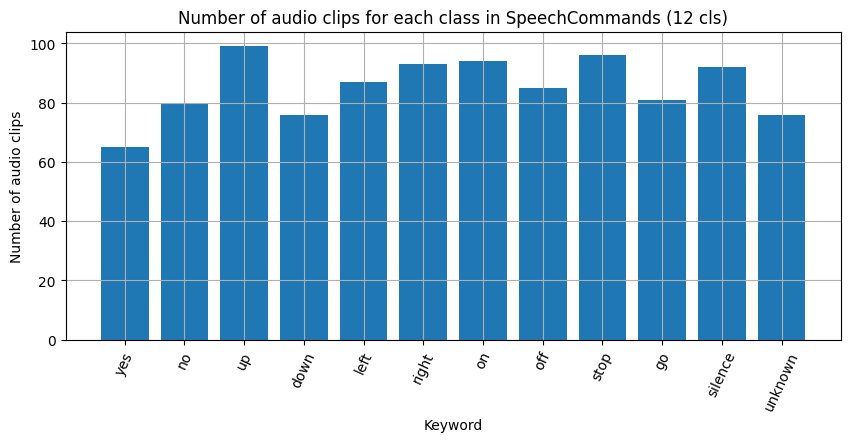

In [30]:
balanced_train_set = balance_dataset(full_train_set, target_column="target")
train_loader = DataLoader(balanced_train_set, batch_size=1024, shuffle=True)
# Let's extract the first batch
batch = next(iter(train_loader))

# Indeed you'll see the same distribution
viz_histogram(batch["target"])

## Getting Ready for FL with Flower

In Federated Learning, each client keeps its own data and nevere shares it with the central server. Instead, each client locally trains an AI model with its data, then communicates it back to the central server for aggregation. The Speech Commands dataset is _naturally_ partitioned, meaning that each of the 1-second audio clips was recorded by a real human. If we inspect the dataset features once more, you'll see there is a column named `speaker_id`

In [31]:
print(sc_train)

# And if we count how many unique `speaker_id` entries there are
unique_speakers = set(sc_train['speaker_id'])
print(f"Number of unique speaker_ids: {len(unique_speakers)}") # 2112 + 1 (i.e. the "background" sounds)

Dataset({
    features: ['file', 'audio', 'label', 'is_unknown', 'speaker_id', 'utterance_id'],
    num_rows: 84848
})
Number of unique speaker_ids: 2113


So we have a total of 2112 individual speaker. We want to preserve these partitions, one for each FL client.

But how to easily access each of those partitions? how to inspect them individually while we are putting together our Flower App? Let's use [Flower Datasets](https://flower.ai/docs/datasets/)!

In [32]:
from flwr_datasets import FederatedDataset
# We'll use the NaturalIdPartitioner (but there are many other partitioners to choose from)
from flwr_datasets.partitioner import NaturalIdPartitioner
from flwr_datasets.visualization import plot_label_distributions

With Flower Datasets you can download, partition and pre-process most (all?) datasets available in Hugging Face (over 300K at the time of writing). You can also use Flower Datasets to load and partition your own local dataset.

Let's use Flower Datasets to download and partition the SpeechCommands dataset

In [33]:
fds = FederatedDataset(
    dataset="google/speech_commands",
    subset="v0.02",
    partitioners={
        "train": NaturalIdPartitioner(
            partition_by="speaker_id",
        ),
    },
)

partitioner = fds.partitioners["train"]
print(f"{partitioner.num_partitions = }")

/Users/javier/.pyenv/versions/icassp-fl/lib/python3.11/site-packages/flwr_datasets/utils.py:109: UserWarning: The currently tested dataset are ['mnist', 'ylecun/mnist', 'cifar10', 'uoft-cs/cifar10', 'fashion_mnist', 'zalando-datasets/fashion_mnist', 'sasha/dog-food', 'zh-plus/tiny-imagenet', 'scikit-learn/adult-census-income', 'cifar100', 'uoft-cs/cifar100', 'svhn', 'ufldl-stanford/svhn', 'sentiment140', 'stanfordnlp/sentiment140', 'speech_commands', 'LIUM/tedlium', 'flwrlabs/femnist', 'flwrlabs/ucf101', 'flwrlabs/ambient-acoustic-context', 'jlh/uci-mushrooms', 'Mike0307/MNIST-M', 'flwrlabs/usps', 'scikit-learn/iris', 'flwrlabs/pacs', 'flwrlabs/cinic10', 'flwrlabs/caltech101', 'flwrlabs/office-home', 'flwrlabs/fed-isic2019']. Given: google/speech_commands.
  warnings.warn(


partitioner.num_partitions = 2113


With Flower Datasets we can also inspect the distribution of each dataset partition. Let's see what the original 35-classes dataset looks like when partitioned according to `speaker_id`. Can you spot the heterogeneity of this dataset?

Generating partition_id_to_indices: 84848it [00:00, 6862421.29it/s]


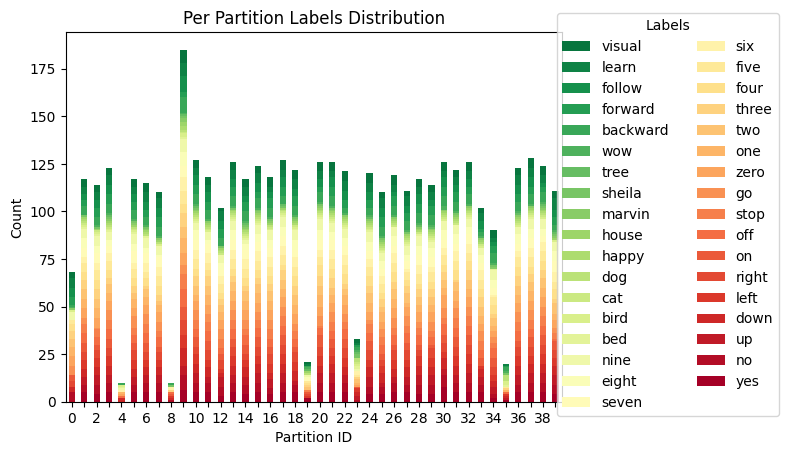

In [34]:
# Use the built-in visualization tools in Flower Datasets
# More at: https://flower.ai/docs/datasets/tutorial-visualize-label-distribution.html
fix, ax, df = plot_label_distributions(
    partitioner=partitioner,
    label_name="label",
    max_num_partitions=40,
    plot_type="bar",
    partition_id_axis="x",
    legend=True,
    title="Per Partition Labels Distribution",
    verbose_labels=True,
    legend_kwargs={"ncols": 2, "bbox_to_anchor": (1.25, 0.5)},
)

While working with 2112 individual clients (i.e. one per `spearker_id`) is totally fine, we'll be grouping them into clusters of speakers. Each will have 20 unique speakers. This will result into 105 clients. You can think of each client representing an office where multiple people interact with a smart speaker system.

In [35]:
from flwr_datasets.partitioner import GroupedNaturalIdPartitioner

partitioner = GroupedNaturalIdPartitioner(
    partition_by="speaker_id", group_size=20
)
fds = FederatedDataset(
    dataset="google/speech_commands",
    subset="v0.02",
    partitioners={
        "train": partitioner
    },
)

# Let's load the first partition
partition = fds.load_partition(0)
# Let's check it's features
print(partition)

# And if we want to inspect how many partitions there are
print(f"{partitioner.num_partitions = }")

/Users/javier/.pyenv/versions/icassp-fl/lib/python3.11/site-packages/flwr_datasets/utils.py:109: UserWarning: The currently tested dataset are ['mnist', 'ylecun/mnist', 'cifar10', 'uoft-cs/cifar10', 'fashion_mnist', 'zalando-datasets/fashion_mnist', 'sasha/dog-food', 'zh-plus/tiny-imagenet', 'scikit-learn/adult-census-income', 'cifar100', 'uoft-cs/cifar100', 'svhn', 'ufldl-stanford/svhn', 'sentiment140', 'stanfordnlp/sentiment140', 'speech_commands', 'LIUM/tedlium', 'flwrlabs/femnist', 'flwrlabs/ucf101', 'flwrlabs/ambient-acoustic-context', 'jlh/uci-mushrooms', 'Mike0307/MNIST-M', 'flwrlabs/usps', 'scikit-learn/iris', 'flwrlabs/pacs', 'flwrlabs/cinic10', 'flwrlabs/caltech101', 'flwrlabs/office-home', 'flwrlabs/fed-isic2019']. Given: google/speech_commands.
  warnings.warn(


Dataset({
    features: ['file', 'audio', 'label', 'is_unknown', 'speaker_id', 'utterance_id'],
    num_rows: 2071
})
partitioner.num_partitions = 106


We can again visualize the distribution over the labels for each partition.

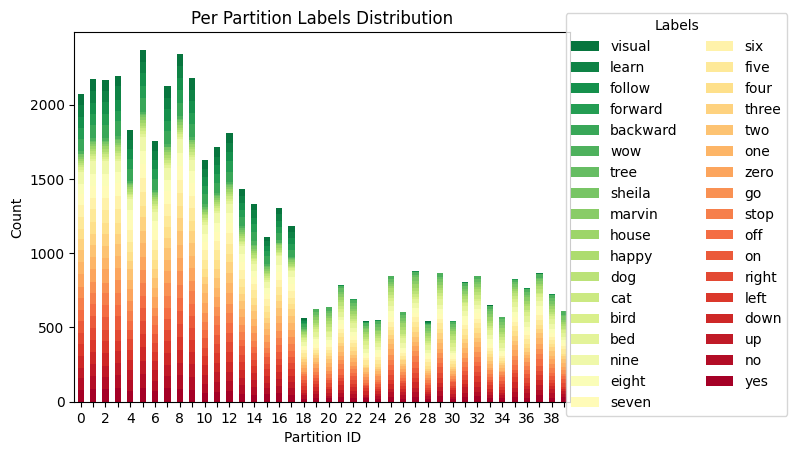

In [36]:
fix, ax, df = plot_label_distributions(
    partitioner=partitioner,
    label_name="label",
    max_num_partitions=40,
    plot_type="bar",
    partition_id_axis="x",
    legend=True,
    title="Per Partition Labels Distribution",
    verbose_labels=True,
    legend_kwargs={"ncols": 2, "bbox_to_anchor": (1.25, 0.5)},
)